### setup

In [20]:
import pandas as pd
import numpy as np
import time
from scipy.optimize import differential_evolution as de

### functions

In [21]:
def theorical_temperature(data):
    initial_temperature = data.temperature.iloc[0]
    heating_rate = 5 # K/min
    return initial_temperature + (heating_rate/60) * data.time

def conversion(data):
    initial_mass = data.tga.iloc[0]
    final_mass = data.tga.iloc[-1]
    return (initial_mass - data.tga) / (initial_mass - final_mass)

def conversion_rate(order, data):
    return (1 - data.conversion)**order

def arrhenius(X, data):
    gas_constant = 8.314 # J/mol*K
    return X[0] * np.exp( -X[1] / (gas_constant * data.theoretical_temperature)) * conversion_rate(X[2], data)

def rpi_model_for_mass(X, data):
    return X[0] * arrhenius(X[1:], data)

def objective_function(X, data):
    data['conversion'] = conversion(data)
    data['theoretical_temperature'] = theorical_temperature(data)
    
    # Decoupling the parameters make it easier to work them out
    hemicellulose_params = X[:4]
    cellulose_params = X[4:8]
    lignin_params = X[8:]

    model_hemicellulose = rpi_model_for_mass(hemicellulose_params, data)
    model_cellulose = rpi_model_for_mass(cellulose_params, data)
    model_lignin = rpi_model_for_mass(lignin_params, data)

    complete_model = model_hemicellulose + model_cellulose + model_lignin

    data['model_hemicellulose'] = model_hemicellulose
    data['model_cellulose'] = model_cellulose
    data['model_lignin'] = model_lignin
    data['RPI_model'] = complete_model
    data['err'] = (data['RPI_model'] - data['dtga'])**2
    
    # the sum returned is needed for the DE optimization
    return data.err.sum()

def run_optimization(data):
    # hemicellulose = initial_values[:4]
    # cellulose = initial_values[4:8]
    # lignin = initial_values[8:]
    
    # Bounds follows: [(component_fraction), (pre_exp_factor), (activation_energy), (order)]
    # range_lower = 0.8
    # range_upper = 1.2

    # hemicellulose = [(range_lower * hemicellulose[0], range_upper * hemicellulose[0]), 
    #                 (range_lower * hemicellulose[1], range_upper * hemicellulose[1]),
    #                 (range_lower * hemicellulose[2], range_upper * hemicellulose[2]),
    #                 (range_lower * hemicellulose[3], range_upper * hemicellulose[3])
    #                 ]

    # cellulose = [(range_lower * cellulose[0], range_upper * cellulose[0]), 
    #             (range_lower * cellulose[1], range_upper * cellulose[1]),
    #             (range_lower * cellulose[2], range_upper * cellulose[2]),
    #             (range_lower * cellulose[3], range_upper * cellulose[3])
    #             ]

    # lignin = [(range_lower * lignin[0], range_upper * lignin[0]), 
    #         (range_lower * lignin[1], range_upper * lignin[1]),
    #         (range_lower * lignin[2], range_upper * lignin[2]),
    #         (range_lower * lignin[3], range_upper * lignin[3])
    #         ]
    hemicellulose = [(0, 0.5), (0, 1e7), (0, 1e7), (0, 2)]
    cellulose = [(0, 0.5), (0, 1e20), (0, 1e7), (0, 2)]
    lignin = [(0, 0.5), (0, 1e5), (0, 1e5), (0, 5)]

    bounds = hemicellulose + cellulose + lignin

    results = de(objective_function, 
                bounds = bounds,
                args = (data, ),
                tol = 1e-5
                )

    return results

def plot_data(data, hemicellulose, cellulose, lignin):
    model_hemicellulose = rpi_model_for_mass(hemicellulose, data)
    model_cellulose = rpi_model_for_mass(cellulose, data)
    model_lignin = rpi_model_for_mass(lignin, data)

    complete_model = model_hemicellulose + model_cellulose + model_lignin

    data['conversion'] = conversion(data)
    data['theoretical_temperature'] = theorical_temperature(data)
    data['model_hemicellulose'] = model_hemicellulose
    data['model_cellulose'] = model_cellulose
    data['model_lignin'] = model_lignin
    data['RPI_model'] = complete_model
    data['err'] = (data['RPI_model'] - data['dtga'])**2

    data.plot(x='time',
              y=['dtga','model_hemicellulose', 'model_cellulose', 'model_lignin'],
              kind='line',
              figsize=(8,4),
              label=['experimental data', 'hemicellulose', 'cellulose', 'lignin'],
              xlabel='time (s)',
              ylabel='mass loss (mg/s)');


### main script

In [22]:
# initial guess based on previous runs and the literature
hemicellulose = [0.19720572528433755, 17264203.728679888, 92698.90110479473, 2.3498070093574377]
cellulose = [0.11947264198247719, 5653485269.68579, 227708.36832928084, 2.6411953119912]
lignin = [0.03016905607975722, 97.18424820779632, 74080.98179618502, 20.549015563342053]

# Function value: 0.0008215107710852468

In [ ]:
data = pd.read_csv('dados\MC carpel H 5-min.csv')
data.dtga = -1 * data.dtga
data = data.drop('dtga_5', axis=1)
tol = 1e-10
opt_fun = 1
counter = 1

stop_criteria = opt_fun > tol or counter < 100

while opt_fun > tol:    
    # initial_values = hemicellulose + cellulose + lignin

    initial_time = time.time()
    results = run_optimization(data)
    final_time = time.time()
    elapsed_time = final_time - initial_time

    params = results.x
    opt_fun = results.fun
    hemicellulose = list(params[:4])
    cellulose = list(params[4:8])
    lignin = list(params[8:])
    print(f'counter: {counter} -- opt_fun = {opt_fun} -- elapsed time = {elapsed_time} seconds')
    counter += 1

print(f"""Results:
------------------------------------------
hemicellulose = {hemicellulose}
cellulose = {cellulose}
lignin = {lignin}

# Function value: {opt_fun}
------------------------------------------
""")

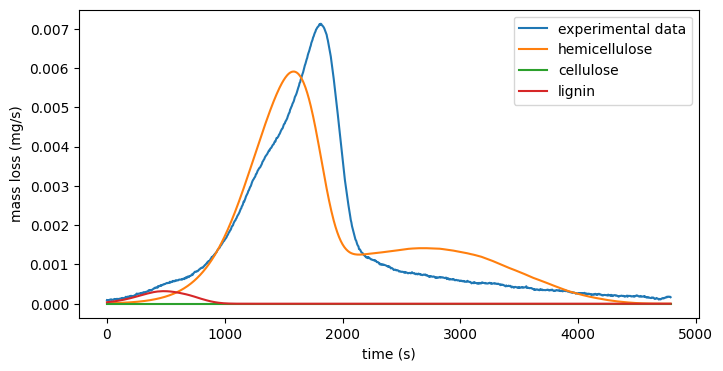

In [ ]:
plot_data(data, hemicellulose, cellulose, lignin)